<a href="https://colab.research.google.com/github/LinuxFan2718/selfplay/blob/main/reinforcement_learning_connect_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update
!apt-get install -y cmake libopenmpi-dev python3-dev zlib1g-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [913 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 k

In [2]:
!pip install 'tensorflow==1.15.0'
!pip install 'gym==0.21.0'
!pip install kaggle_environments
!pip install "stable-baselines[mpi]==2.10.2"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 23 kB/s 
     |████████████████████████████████| 503 kB 66.7 MB/s 
     |████████████████████████████████| 50 kB 7.6 MB/s 
     |████████████████████████████████| 3.8 MB 55.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=72b9bf6f0acae25bf7d09e7394687cdf66b18631ec9de4f55ac4a4916477bb26
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting un

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from kaggle_environments import make, evaluate
from gym import spaces
from stable_baselines.bench import Monitor 
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO1, A2C, ACER, ACKTR, TRPO
from stable_baselines.common.tf_layers import conv, linear, conv_to_fc
from stable_baselines.common.policies import CnnPolicy
%matplotlib inline

class ConnectFourGym:
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(self.rows,self.columns,1), dtype=int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1)
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1), reward, done, _
    
# Create ConnectFour environment
env = ConnectFourGym(agent2="random")

# Create directory for logging training information
log_dir = "log/"
os.makedirs(log_dir, exist_ok=True)

# Logging progress
monitor_env = Monitor(env, log_dir, allow_early_resets=True)

# Create a vectorized environment
vec_env = DummyVecEnv([lambda: monitor_env])

# Neural network for predicting action values
def modified_cnn(scaled_images, **kwargs):
    activ = tf.nn.relu
    layer_1 = activ(conv(scaled_images, 'c1', n_filters=32, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = activ(conv(layer_1, 'c2', n_filters=64, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = conv_to_fc(layer_2)
    return activ(linear(layer_2, 'fc1', n_hidden=512, init_scale=np.sqrt(2)))  

class CustomCnnPolicy(CnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicy, self).__init__(*args, **kwargs, cnn_extractor=modified_cnn)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documen















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


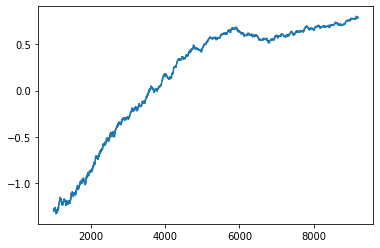

In [4]:
# Initialize agent
model = PPO1(CustomCnnPolicy, vec_env, verbose=0)

# Train agent
model.learn(total_timesteps=80000)

# Plot cumulative reward
with open(os.path.join(log_dir, "monitor.csv"), 'rt') as fh:    
    firstline = fh.readline()
    assert firstline[0] == '#'
    df = pd.read_csv(fh, index_col=None)['r']
df.rolling(window=1000).mean().plot()
plt.show()

In [13]:
type(model)

stable_baselines.ppo1.pposgd_simple.PPO1